# Exploring Dandiset 001359: Human Patch-seq Data from the Allen Institute

**AI-assisted notebook: Please review all code and results carefully before drawing conclusions.**

---

This notebook introduces and explores [Dandiset 001359 ("20250331_AIBS_Patchseq_human")](https://dandiarchive.org/dandiset/001359/0.250401.1603), a rich single-cell multimodal dataset from the Allen Institute for Brain Science. The Dandiset contains human Patch-seq data: each experiment aligns single-cell electrophysiology with transcriptomics and, in some cases, morphology.

### What you'll find in this notebook:

- A structured introduction to the organization and content of Dandiset 001359
- Step-by-step code to list, access, and explore NWB files via the DANDI API
- Guided exploration of NWB metadata, subject information, and experimental structure
- Demonstrations of data visualization for electrophysiological sweeps, stimulus protocols, and detected spike times
- Strategies for scaling your analysis to multiple sessions and subjects

**Note:** This notebook loads NWB data via *remote streaming* for efficiency—no files are downloaded locally.

---

## Required Python Packages

To run the analyses below, you will need the following packages (assumed to be pre-installed):

- `dandi`
- `pynwb`
- `remfile`
- `h5py`
- `numpy`
- `pandas`
- `matplotlib`

The notebook is compatible with DANDI and NWB file streaming and exploration as shown below.

## 1. Exploring the Structure of Dandiset 001359

Let's begin by connecting to the Dandiset and listing some NWB files. We'll extract subject and session information directly from file paths—this is much faster than opening each NWB file.

In [1]:
from dandi.dandiapi import DandiAPIClient
from itertools import islice
import re

# Connect to the DANDI Archive and access this Dandiset by ID and version
dandiset_id = "001359"
dandiset_version = "0.250401.1603"
client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# List a sample of NWB files and extract subject/session from file paths (no download)
assets = list(islice(dandiset.get_assets_by_glob('*.nwb'), 20))  # Example: first 20 files

nwb_info = []
for asset in assets:
    match = re.match(r'sub-(\d+)/(sub-(\d+)_ses-(\d+)_icephys.nwb)', asset.path)
    if match:
        subject_id = match.group(1)
        session_id = match.group(4)
        nwb_info.append((asset.path, subject_id, session_id))
    else:
        nwb_info.append((asset.path, 'N/A', 'N/A'))

print(f"{'File path':70} | Subject | Session")
print('-'*95)
for path, sub, ses in nwb_info:
    print(f"{path:70} | {sub:7} | {ses}")

File path                                                              | Subject | Session
-----------------------------------------------------------------------------------------------
sub-1203384279/sub-1203384279_ses-1207984257_icephys.nwb               | 1203384279 | 1207984257
sub-1203384279/sub-1203384279_ses-1207304122_icephys.nwb               | 1203384279 | 1207304122
sub-1203384279/sub-1203384279_ses-1207262032_icephys.nwb               | 1203384279 | 1207262032
sub-1203384279/sub-1203384279_ses-1207418023_icephys.nwb               | 1203384279 | 1207418023
sub-1203384279/sub-1203384279_ses-1208065964_icephys.nwb               | 1203384279 | 1208065964
sub-1213383385/sub-1213383385_ses-1213430531_icephys.nwb               | 1213383385 | 1213430531
sub-1211237280/sub-1211237280_ses-1211340847_icephys.nwb               | 1211237280 | 1211340847
sub-1213383385/sub-1213383385_ses-1213420947_icephys.nwb               | 1213383385 | 1213420947
sub-1213383385/sub-1213383385_ses-121

> **Explanation:**  
> Each subject (`sub-...`) can have multiple sessions (`ses-...`). Data is organized by subject/session in the file path naming—no need to load NWB files just to see what subjects and sessions are present!

The naming convention provides a simple and scalable way to organize and filter the data.

## 2. Loading Metadata and Viewing the Overall Structure of a NWB File

We'll stream a single NWB file from the Dandiset and explore its high-level content, including:
- Subject metadata
- Session metadata
- Number and type of electrophysiological sweeps
- Experimental epochs and tagging

In [2]:
import remfile
import h5py
import pynwb

# Select an example file (adjust as needed)
example_asset = assets[0]
example_url = example_asset.download_url

# Stream the NWB file using remfile and h5py
remote_file = remfile.File(example_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Print subject and session info
subject = nwb.subject
session_id = nwb.session_id if hasattr(nwb, "session_id") else "N/A"
print("Subject info:")
print(f"  Subject ID: {subject.subject_id}")
print(f"  Age: {subject.age}")
print(f"  Sex: {subject.sex}")
print(f"  Species: {subject.species}")
print(f"Session ID: {session_id}")

# -- SWEEPS TABLE
df_sweeps = nwb.sweep_table.to_dataframe()
print(f"\nTotal number of sweeps: {len(df_sweeps)}")
print("First 10 rows of the sweep table:")
print(df_sweeps.head(10))

# -- EPOCHS TABLE
epochs_df = nwb.epochs.to_dataframe()
print(f"\nTotal number of epochs: {len(epochs_df)}")
print("First 5 rows of the epochs table:")
print(epochs_df[['start_time','stop_time','tags']].head())

/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.4 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Subject info:
  Subject ID: 1203384279
  Age: P21170.0D
  Sex: M
  Species: Homo sapiens
Session ID: 1207984257

Total number of sweeps: 132
First 10 rows of the sweep table:
                                               series  sweep_number
id                                                                 
0   [data_00000_AD0 pynwb.icephys.VoltageClampSeri...             0
1   [data_00000_DA0 pynwb.icephys.VoltageClampStim...             0
2   [data_00001_AD0 pynwb.icephys.VoltageClampSeri...             1
3   [data_00001_DA0 pynwb.icephys.VoltageClampStim...             1
4   [data_00002_AD0 pynwb.icephys.VoltageClampSeri...             2
5   [data_00002_DA0 pynwb.icephys.VoltageClampStim...             2
6   [data_00003_AD0 pynwb.icephys.VoltageClampSeri...             3
7   [data_00003_DA0 pynwb.icephys.VoltageClampStim...             3
8   [data_00004_AD0 pynwb.icephys.VoltageClampSeri...             4
9   [data_00004_DA0 pynwb.icephys.VoltageClampStim...             4



Total number of epochs: 3352
First 5 rows of the epochs table:
    start_time  stop_time                                               tags
id                                                                          
1       12.918     12.963  [Type=Inserted Testpulse, SubType=Baseline, Sh...
2       12.918     13.018            [Type=Inserted Testpulse, ShortName=TP]
3       12.963     12.973  [Type=Inserted Testpulse, SubType=Pulse, Ampli...
4       12.973     13.018  [Type=Inserted Testpulse, SubType=Baseline, Sh...
5       13.018     13.518   [Name=Baseline Chunk, Index=0, ShortName=U_BLC0]


> **Explanation:**  
> - **Sweeps**: Each experiment is divided into sweeps (trials), with acquisition and stimulus series.  
> - **Epochs**: Fine-grained annotation—protocol details, baseline/chunk tagging, etc.  
> - **Subject/session metadata**: Available for every NWB file, allowing batch or stratified analysis.

Each sweep includes protocol-relevant time series, ready for visualization and further analysis.

## 3. Visualizing Electrophysiological Traces and Stimulus Protocols

Next, we'll demonstrate how to explore and visualize the electrophysiology data and its corresponding stimulus protocol. The dataset contains both Current Clamp and Voltage Clamp sweeps. We'll present one of each.

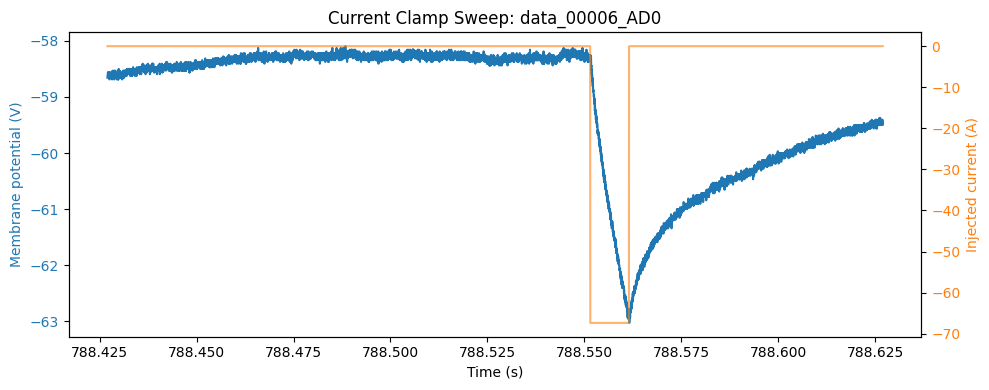

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Find keys for a current clamp and a voltage clamp sweep
acq_keys = list(nwb.acquisition.keys())

# Get first available CurrentClampSeries (unit: volts) and VoltageClampSeries (unit: amperes)
cc_key = None
vc_key = None
for k in acq_keys:
    obj = nwb.acquisition[k]
    if getattr(obj, "unit", None) == "volts" and cc_key is None:
        cc_key = k
    if getattr(obj, "unit", None) == "amperes" and vc_key is None:
        vc_key = k
    if cc_key and vc_key:
        break

# --- Plot CURRENT CLAMP sweep (membrane voltage & injected current) ---
datacc = nwb.acquisition[cc_key]
stimcc = nwb.stimulus[cc_key.replace("_AD0", "_DA0")]

N = min(10000, datacc.data.shape[0])
t_cc = np.arange(N) / datacc.rate + datacc.starting_time
v_cc = datacc.data[:N]
i_stim = stimcc.data[:N]

fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(t_cc, v_cc, label='Membrane voltage', color='tab:blue')
ax1.set_ylabel('Membrane potential (V)', color='tab:blue')
ax1.set_xlabel('Time (s)')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.plot(t_cc, i_stim, label='Injected current', color='tab:orange', alpha=0.6)
ax2.set_ylabel('Injected current (A)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
plt.title(f'Current Clamp Sweep: {cc_key}')
fig.tight_layout()
plt.show()

> **Interpretation:**  
> The blue trace shows the membrane voltage response to an injected current pulse (orange trace).  
> You can change the keys or the length `N` to visualize other parts of any sweep.

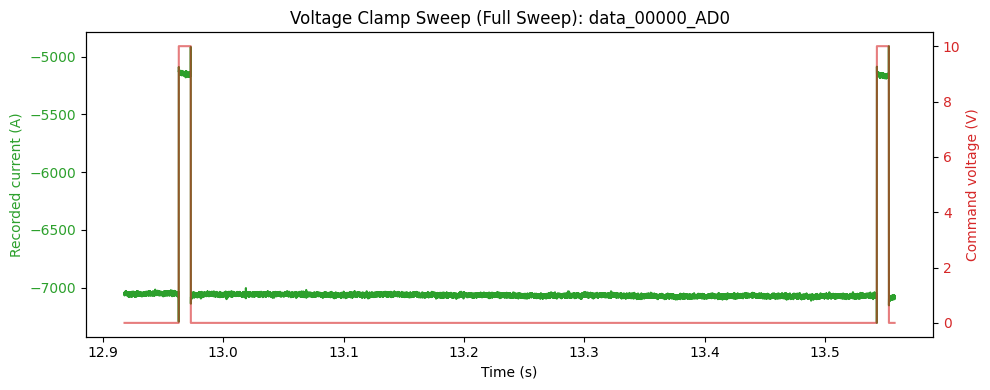

In [4]:
# --- Plot FULL Voltage Clamp sweep (recorded current & command voltage) ---
datavc = nwb.acquisition[vc_key]
stimvc = nwb.stimulus[vc_key.replace("_AD0", "_DA0")]

data_len = datavc.data.shape[0]
t_vc = np.arange(data_len) / datavc.rate + datavc.starting_time
I_vc = datavc.data[:]
V_cmd = stimvc.data[:]

fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(t_vc, I_vc, label='Recorded current', color='tab:green')
ax1.set_ylabel('Recorded current (A)', color='tab:green')
ax1.set_xlabel('Time (s)')
ax1.tick_params(axis='y', labelcolor='tab:green')
ax2 = ax1.twinx()
ax2.plot(t_vc, V_cmd, label='Command voltage', color='tab:red', alpha=0.6)
ax2.set_ylabel('Command voltage (V)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.title(f'Voltage Clamp Sweep (Full Sweep): {vc_key}')
fig.tight_layout()
plt.show()

> **Interpretation:**  
> The green trace is the measured ionic current in response to voltage steps (red trace).  
> Viewing the full sweep helps you identify when commands were applied and see both baseline and evoked responses.

## 4. Inspecting and Visualizing Detected Spike Events

Many files contain processed spike detection results, labeled by sweep (under `processing["spikes"]`). We'll show how to plot detected spike times for a representative sweep.

Spike interface keys (first 8): ['Sweep_12', 'Sweep_19', 'Sweep_20', 'Sweep_21', 'Sweep_22', 'Sweep_24', 'Sweep_25', 'Sweep_26']
Sweep 'Sweep_19' spike times (s): [1.1886  1.22502 1.257   1.27972 1.30116 1.32368 1.3469  1.36998 1.39572
 1.42466 1.45246 1.4835 ]


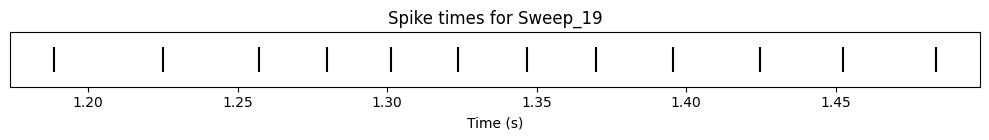

In [5]:
# Get the spikes processing module and list its keys
if "spikes" in nwb.processing:
    detect_spikes = nwb.processing['spikes']
    spike_keys = list(detect_spikes.data_interfaces.keys())
    print(f"Spike interface keys (first 8): {spike_keys[:8]}")

    # Example: Show the spike raster for the first sweep with any spikes
    sweep_with_spikes = None
    spike_times = None
    for key in spike_keys:
        st = detect_spikes.data_interfaces[key].timestamps[:]
        if len(st):
            sweep_with_spikes = key
            spike_times = st
            break
    if spike_times is not None:
        print(f"Sweep '{sweep_with_spikes}' spike times (s): {spike_times}")

        fig, ax = plt.subplots(figsize=(10, 1.5))
        ax.eventplot(spike_times, colors='k')
        ax.set_title(f'Spike times for {sweep_with_spikes}')
        ax.set_xlabel('Time (s)')
        ax.set_yticks([])
        plt.tight_layout()
        plt.show()
    else:
        print("No spikes detected in the first 8 sweeps of spikes module in this file.")
else:
    print("No 'spikes' processing module found in this NWB file.")

> **Explanation:**  
> Each vertical bar in the raster plot represents a spike time as detected during that sweep.  
> You can easily loop through other keys to see spike times for different protocols or sweeps.

## 5. Best Practices for Scaling Up

- Use the file path parsing strategy to **list and select** sessions/subjects rapidly across the Dandiset.
- Use the Dandiset's structure to design batch, per-subject, or protocol-level analyses—without loading all files at once.
- Load and stream individual NWB files only for the subjects, sessions, and sweeps you need.
- Use the sweep and epoch tables (`sweep_table`, `epochs`) to organize and filter experiments programmatically.

---

## Next Steps

- Adapt the example code to plot additional sweeps (change `cc_key`, `vc_key`, or sweep numbers) as needed.
- Extract features (e.g., spike counts, firing rate) using the spike tables and epochs for your own analyses.
- Explore additional DANDI datasets and NWB tools for richer reanalysis.

---

## Summary

This notebook guided you through Dandiset 001359: human Patch-seq single-cell experiments, showing you how to:
- Explore the dataset structure and metadata without loading all NWB files
- Investigate and visualize representative sweeps, epochs, and spike events from real experimental data
- Prepare for custom analyses and scalable exploration

> **Remember:** This notebook was generated with AI assistance. Please review any code and results carefully before publication or downstream use.